# LU Matrix Factorization

## Introduction

LU decomposition (or LU factorization) is a fundamental technique in numerical linear algebra that factors a matrix $A$ into the product of a lower triangular matrix $L$ and an upper triangular matrix $U$:

$$A = LU$$

This decomposition is particularly valuable for solving systems of linear equations, computing matrix determinants, and finding matrix inverses efficiently.

## Mathematical Foundation

### Definition

For a square matrix $A \in \mathbb{R}^{n \times n}$, the LU decomposition seeks matrices:

$$L = \begin{pmatrix} 1 & 0 & \cdots & 0 \\ l_{21} & 1 & \cdots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ l_{n1} & l_{n2} & \cdots & 1 \end{pmatrix}, \quad U = \begin{pmatrix} u_{11} & u_{12} & \cdots & u_{1n} \\ 0 & u_{22} & \cdots & u_{2n} \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \cdots & u_{nn} \end{pmatrix}$$

where $L$ is unit lower triangular (ones on the diagonal) and $U$ is upper triangular.

### Gaussian Elimination Connection

The LU decomposition is intimately connected to Gaussian elimination. The matrix $L$ stores the multipliers used during elimination:

$$l_{ij} = \frac{a_{ij}^{(j-1)}}{a_{jj}^{(j-1)}}$$

where $a_{ij}^{(k)}$ denotes the $(i,j)$ entry after $k$ elimination steps.

### Algorithm (Doolittle's Method)

For each column $j = 1, 2, \ldots, n$:

1. **Compute elements of $U$ (row $i \leq j$):**
   $$u_{ij} = a_{ij} - \sum_{k=1}^{i-1} l_{ik} u_{kj}$$

2. **Compute elements of $L$ (row $i > j$):**
   $$l_{ij} = \frac{1}{u_{jj}} \left( a_{ij} - \sum_{k=1}^{j-1} l_{ik} u_{kj} \right)$$

### Solving Linear Systems

Given $Ax = b$, with $A = LU$:

1. **Forward substitution:** Solve $Ly = b$ for $y$
   $$y_i = b_i - \sum_{j=1}^{i-1} l_{ij} y_j$$

2. **Back substitution:** Solve $Ux = y$ for $x$
   $$x_i = \frac{1}{u_{ii}} \left( y_i - \sum_{j=i+1}^{n} u_{ij} x_j \right)$$

### Computational Complexity

- **Factorization:** $\mathcal{O}\left(\frac{2n^3}{3}\right)$ operations
- **Forward/Back substitution:** $\mathcal{O}(n^2)$ operations each

This makes LU decomposition efficient when solving multiple systems with the same coefficient matrix.

### Partial Pivoting

To ensure numerical stability, we use partial pivoting, yielding:

$$PA = LU$$

where $P$ is a permutation matrix that reorders rows to place the largest pivot element in position.

## Implementation

We will implement LU decomposition from scratch and compare with SciPy's optimized implementation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lu, solve_triangular
import time

# Set random seed for reproducibility
np.random.seed(42)

print("LU Matrix Factorization - Implementation and Analysis")
print("=" * 55)

LU Matrix Factorization - Implementation and Analysis


### Custom LU Decomposition Implementation

In [2]:
def lu_decomposition_no_pivot(A):
    """
    Perform LU decomposition without pivoting (Doolittle's algorithm).
    
    Parameters:
    -----------
    A : ndarray
        Square matrix to decompose
    
    Returns:
    --------
    L : ndarray
        Unit lower triangular matrix
    U : ndarray
        Upper triangular matrix
    """
    n = A.shape[0]
    L = np.eye(n)
    U = np.zeros((n, n))
    
    for j in range(n):
        # Compute U[i,j] for i <= j
        for i in range(j + 1):
            U[i, j] = A[i, j] - np.dot(L[i, :i], U[:i, j])
        
        # Compute L[i,j] for i > j
        for i in range(j + 1, n):
            if np.abs(U[j, j]) < 1e-12:
                raise ValueError("Zero pivot encountered. Use pivoting.")
            L[i, j] = (A[i, j] - np.dot(L[i, :j], U[:j, j])) / U[j, j]
    
    return L, U


def lu_decomposition_partial_pivot(A):
    """
    Perform LU decomposition with partial pivoting.
    
    Parameters:
    -----------
    A : ndarray
        Square matrix to decompose
    
    Returns:
    --------
    P : ndarray
        Permutation matrix
    L : ndarray
        Unit lower triangular matrix
    U : ndarray
        Upper triangular matrix
    """
    n = A.shape[0]
    U = A.astype(float).copy()
    L = np.eye(n)
    P = np.eye(n)
    
    for k in range(n - 1):
        # Find pivot
        pivot_idx = np.argmax(np.abs(U[k:, k])) + k
        
        # Swap rows
        if pivot_idx != k:
            U[[k, pivot_idx]] = U[[pivot_idx, k]]
            P[[k, pivot_idx]] = P[[pivot_idx, k]]
            if k > 0:
                L[[k, pivot_idx], :k] = L[[pivot_idx, k], :k]
        
        # Elimination
        if np.abs(U[k, k]) > 1e-12:
            for i in range(k + 1, n):
                L[i, k] = U[i, k] / U[k, k]
                U[i, k:] -= L[i, k] * U[k, k:]
    
    return P, L, U

### Demonstration with a Small Matrix

In [3]:
# Create a test matrix
A = np.array([
    [2, -1, -2],
    [-4, 6, 3],
    [-4, -2, 8]
], dtype=float)

print("Original Matrix A:")
print(A)
print()

# Perform LU decomposition without pivoting
L, U = lu_decomposition_no_pivot(A)

print("Lower Triangular Matrix L:")
print(L)
print()

print("Upper Triangular Matrix U:")
print(U)
print()

# Verify: A = LU
print("Verification (L @ U):")
print(L @ U)
print()

print(f"Reconstruction error: {np.linalg.norm(A - L @ U):.2e}")

Original Matrix A:
[[ 2. -1. -2.]
 [-4.  6.  3.]
 [-4. -2.  8.]]

Lower Triangular Matrix L:
[[ 1.  0.  0.]
 [-2.  1.  0.]
 [-2. -1.  1.]]

Upper Triangular Matrix U:
[[ 2. -1. -2.]
 [ 0.  4. -1.]
 [ 0.  0.  3.]]

Verification (L @ U):
[[ 2. -1. -2.]
 [-4.  6.  3.]
 [-4. -2.  8.]]

Reconstruction error: 0.00e+00


### LU Decomposition with Partial Pivoting

In [4]:
# Test with a matrix that benefits from pivoting
A_pivot = np.array([
    [1e-17, 1],
    [1, 1]
], dtype=float)

print("Matrix requiring pivoting:")
print(A_pivot)
print()

# With partial pivoting
P, L, U = lu_decomposition_partial_pivot(A_pivot)

print("Permutation Matrix P:")
print(P)
print()

print("Lower Triangular Matrix L:")
print(L)
print()

print("Upper Triangular Matrix U:")
print(U)
print()

print("Verification (P @ A = L @ U):")
print(f"P @ A =\n{P @ A_pivot}")
print(f"L @ U =\n{L @ U}")
print(f"Error: {np.linalg.norm(P @ A_pivot - L @ U):.2e}")

Matrix requiring pivoting:
[[1.e-17 1.e+00]
 [1.e+00 1.e+00]]

Permutation Matrix P:
[[0. 1.]
 [1. 0.]]

Lower Triangular Matrix L:
[[1.e+00 0.e+00]
 [1.e-17 1.e+00]]

Upper Triangular Matrix U:
[[1. 1.]
 [0. 1.]]

Verification (P @ A = L @ U):
P @ A =
[[1.e+00 1.e+00]
 [1.e-17 1.e+00]]
L @ U =
[[1.e+00 1.e+00]
 [1.e-17 1.e+00]]
Error: 0.00e+00


### Solving Linear Systems

In [5]:
def forward_substitution(L, b):
    """Solve Ly = b for y using forward substitution."""
    n = len(b)
    y = np.zeros(n)
    for i in range(n):
        y[i] = b[i] - np.dot(L[i, :i], y[:i])
    return y


def back_substitution(U, y):
    """Solve Ux = y for x using back substitution."""
    n = len(y)
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = (y[i] - np.dot(U[i, i+1:], x[i+1:])) / U[i, i]
    return x


def solve_lu(L, U, b, P=None):
    """Solve Ax = b using precomputed LU decomposition."""
    if P is not None:
        b = P @ b
    y = forward_substitution(L, b)
    x = back_substitution(U, y)
    return x


# Example: Solve a system of equations
A = np.array([
    [4, 3, 2],
    [2, 1, 3],
    [3, 4, 1]
], dtype=float)

b = np.array([25, 14, 19], dtype=float)

# LU decomposition with pivoting
P, L, U = lu_decomposition_partial_pivot(A)

# Solve using our implementation
x_lu = solve_lu(L, U, b, P)

# Verify with numpy
x_numpy = np.linalg.solve(A, b)

print("Solving Ax = b")
print("="*40)
print(f"Matrix A:\n{A}")
print(f"\nVector b: {b}")
print(f"\nSolution (LU): {x_lu}")
print(f"Solution (NumPy): {x_numpy}")
print(f"\nDifference: {np.linalg.norm(x_lu - x_numpy):.2e}")
print(f"Verification (A @ x): {A @ x_lu}")

Solving Ax = b
Matrix A:
[[4. 3. 2.]
 [2. 1. 3.]
 [3. 4. 1.]]

Vector b: [25. 14. 19.]

Solution (LU): [5.53846154 0.38461538 0.84615385]
Solution (NumPy): [5.53846154 0.38461538 0.84615385]

Difference: 1.24e-16
Verification (A @ x): [25. 14. 19.]


### Computing Determinant using LU

In [6]:
def determinant_lu(A):
    """
    Compute determinant using LU decomposition.
    det(A) = det(P)^(-1) * det(L) * det(U) = (-1)^s * prod(diag(U))
    """
    P, L, U = lu_decomposition_partial_pivot(A)
    
    # Count row swaps (number of permutations)
    n_swaps = np.sum(np.diag(P) == 0) // 2
    sign = (-1) ** n_swaps
    
    # det(U) = product of diagonal elements
    det_U = np.prod(np.diag(U))
    
    return sign * det_U


# Test determinant calculation
A = np.array([
    [4, 3, 2],
    [2, 1, 3],
    [3, 4, 1]
], dtype=float)

det_lu = determinant_lu(A)
det_numpy = np.linalg.det(A)

print("Determinant Calculation")
print("="*40)
print(f"det(A) using LU: {det_lu:.6f}")
print(f"det(A) using NumPy: {det_numpy:.6f}")

Determinant Calculation
det(A) using LU: -13.000000
det(A) using NumPy: -13.000000


## Performance Analysis

Let's analyze the computational efficiency of LU decomposition compared to direct methods.

In [7]:
# Performance comparison
sizes = [10, 20, 50, 100, 200, 500]
times_lu_factorization = []
times_lu_solve = []
times_direct_solve = []
errors = []

print("Performance Analysis")
print("="*60)

for n in sizes:
    # Generate random matrix and vectors
    A = np.random.randn(n, n)
    # Make it diagonally dominant for stability
    A = A + n * np.eye(n)
    b = np.random.randn(n)
    
    # Time LU factorization
    start = time.time()
    P, L, U = lu(A)
    time_factor = time.time() - start
    times_lu_factorization.append(time_factor)
    
    # Time LU solve (after factorization)
    start = time.time()
    y = solve_triangular(L, P @ b, lower=True)
    x_lu = solve_triangular(U, y, lower=False)
    time_solve = time.time() - start
    times_lu_solve.append(time_solve)
    
    # Time direct solve
    start = time.time()
    x_direct = np.linalg.solve(A, b)
    time_direct = time.time() - start
    times_direct_solve.append(time_direct)
    
    # Compute error
    error = np.linalg.norm(x_lu - x_direct)
    errors.append(error)
    
    print(f"n={n:4d}: LU Factor={time_factor*1000:8.3f}ms, "
          f"LU Solve={time_solve*1000:8.3f}ms, "
          f"Direct={time_direct*1000:8.3f}ms, "
          f"Error={error:.2e}")

Performance Analysis
n=  10: LU Factor=   0.143ms, LU Solve=   0.192ms, Direct=   0.027ms, Error=3.04e-17
n=  20: LU Factor=   0.065ms, LU Solve=   0.062ms, Direct=   0.026ms, Error=3.05e-17
n=  50: LU Factor=   0.146ms, LU Solve=   0.105ms, Direct=   0.067ms, Error=5.05e-17
n= 100: LU Factor=   0.212ms, LU Solve=   0.087ms, Direct=   0.130ms, Error=3.62e-17
n= 200: LU Factor=   0.809ms, LU Solve=   0.153ms, Direct=   0.407ms, Error=3.58e-17
n= 500: LU Factor= 603.096ms, LU Solve=   0.569ms, Direct=   4.601ms, Error=2.88e-17


## Visualization

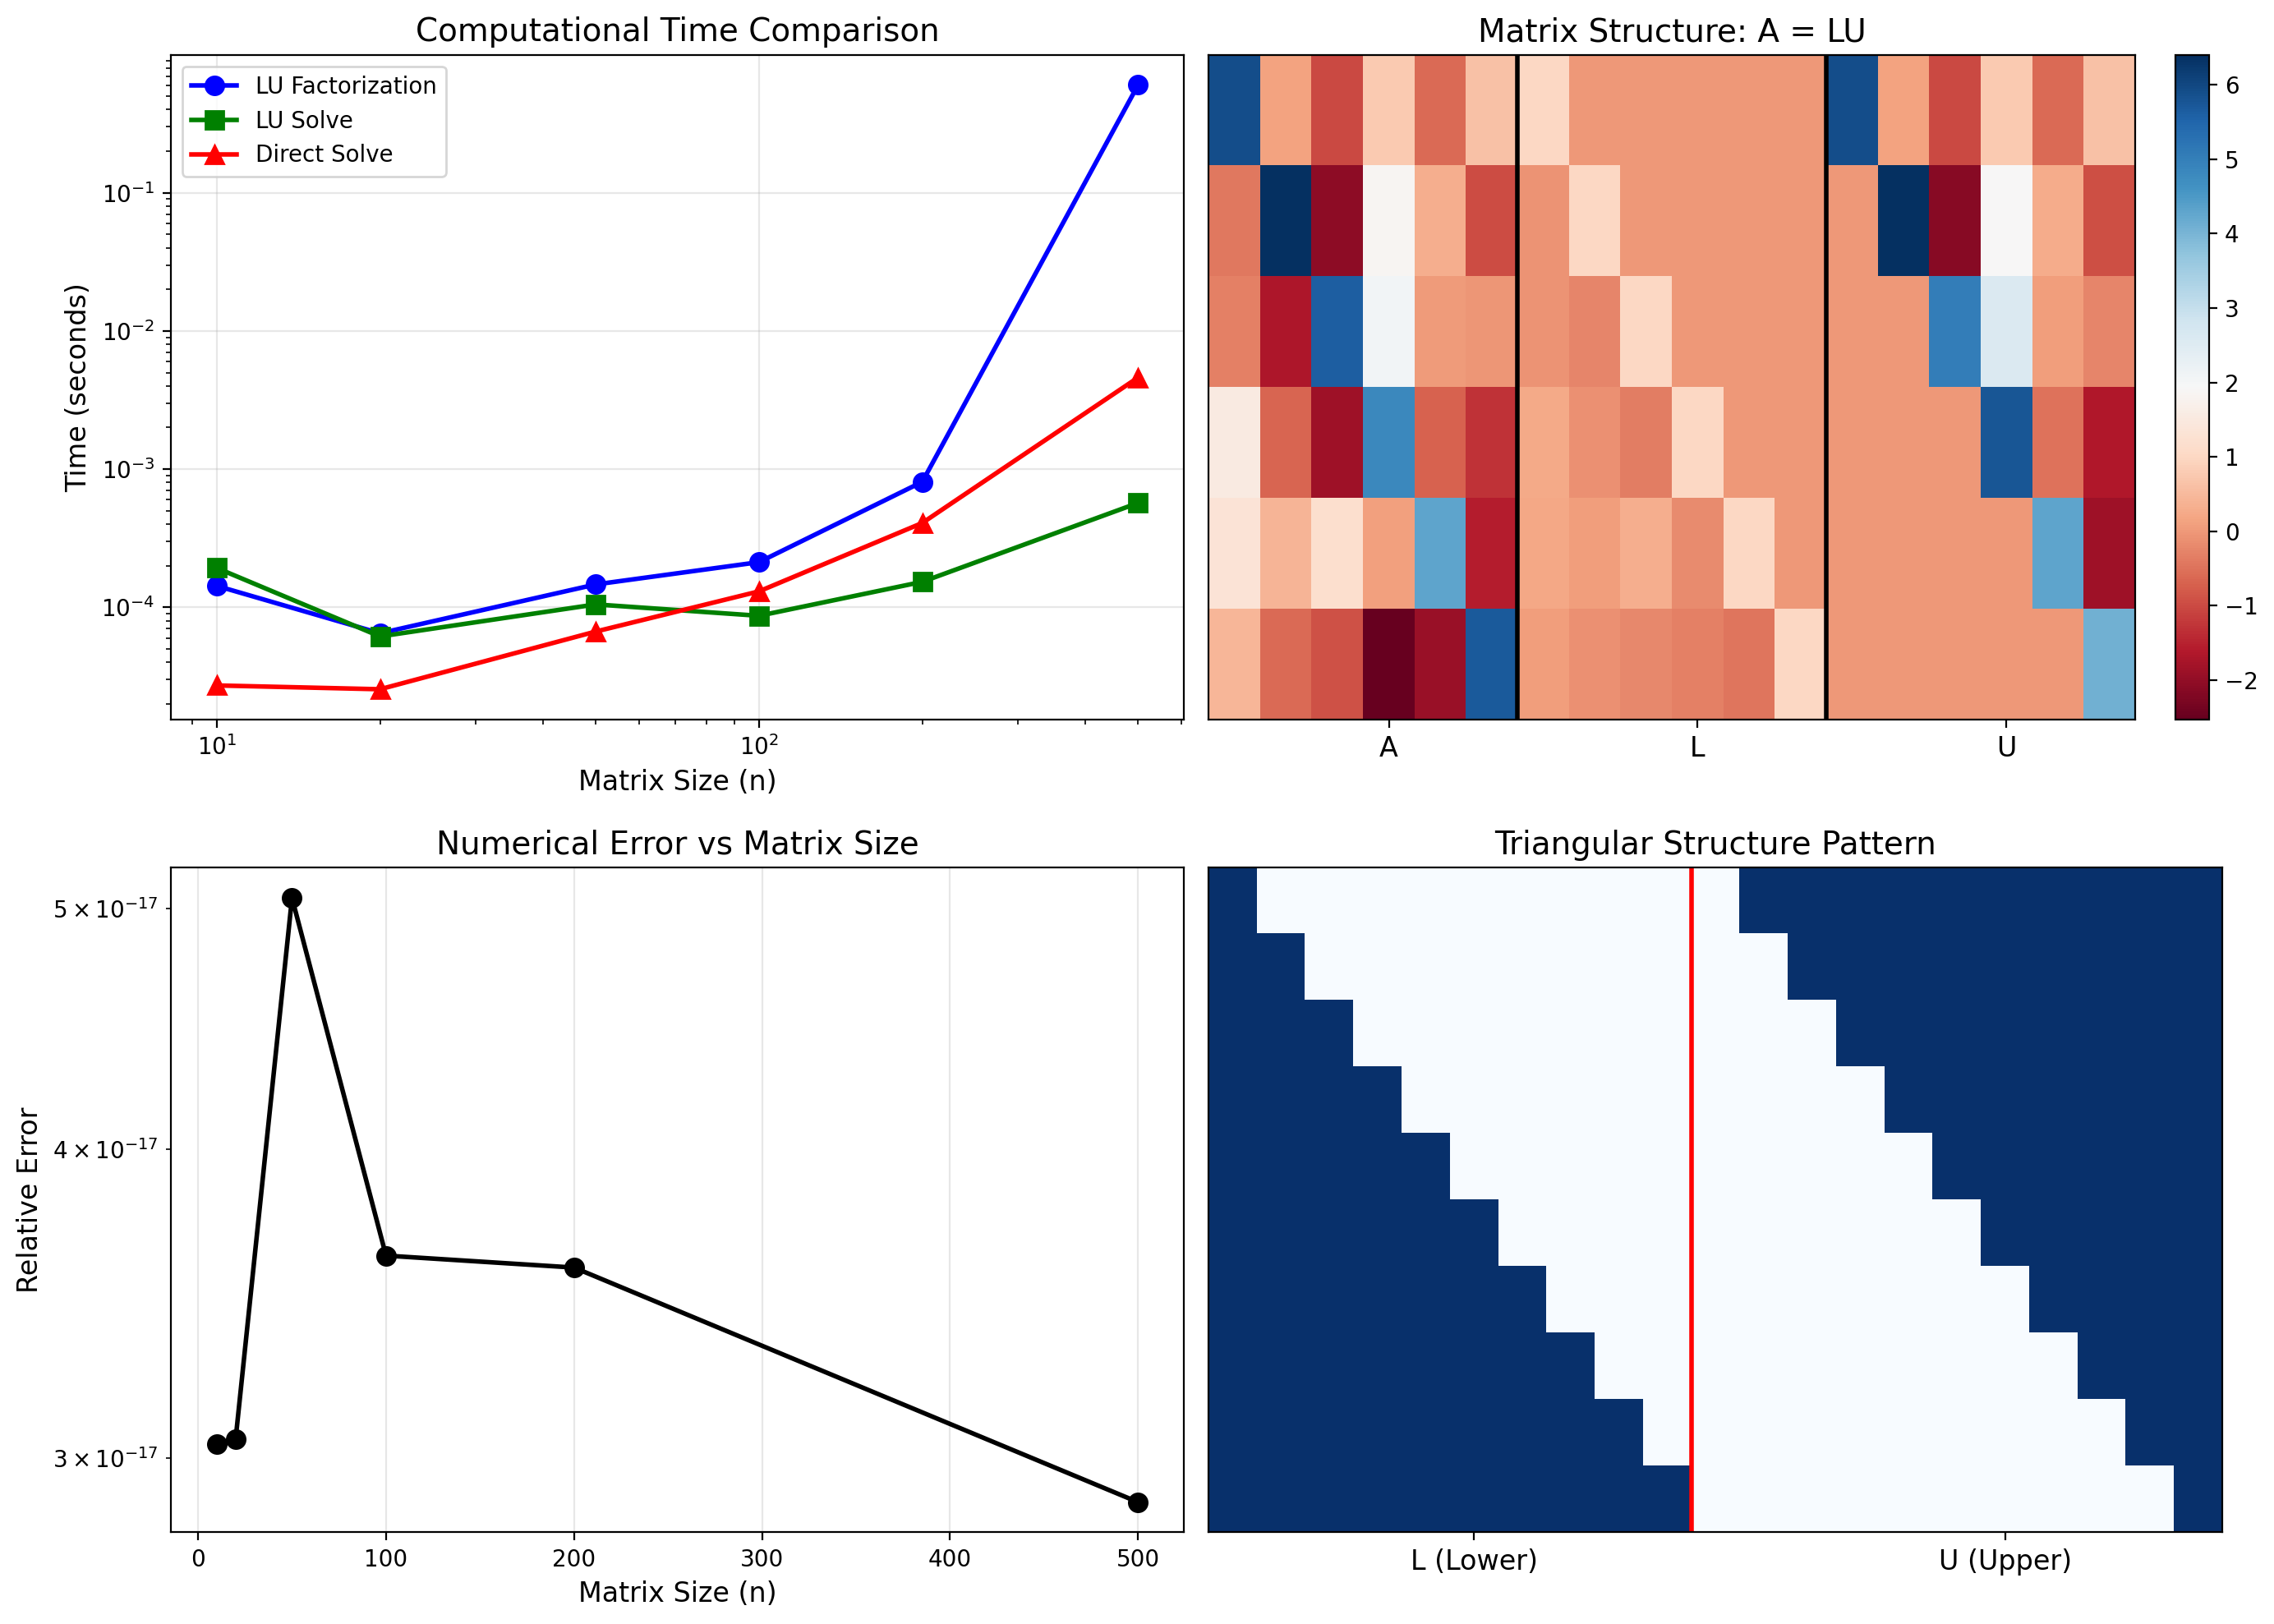


Figure saved to 'plot.png'


In [8]:
# Create comprehensive visualization
fig = plt.figure(figsize=(14, 10))

# Plot 1: Timing comparison
ax1 = fig.add_subplot(2, 2, 1)
ax1.loglog(sizes, times_lu_factorization, 'b-o', label='LU Factorization', linewidth=2, markersize=8)
ax1.loglog(sizes, times_lu_solve, 'g-s', label='LU Solve', linewidth=2, markersize=8)
ax1.loglog(sizes, times_direct_solve, 'r-^', label='Direct Solve', linewidth=2, markersize=8)
ax1.set_xlabel('Matrix Size (n)', fontsize=12)
ax1.set_ylabel('Time (seconds)', fontsize=12)
ax1.set_title('Computational Time Comparison', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Matrix structure visualization
ax2 = fig.add_subplot(2, 2, 2)
A_demo = np.random.randn(6, 6)
A_demo = A_demo + 6 * np.eye(6)
P_demo, L_demo, U_demo = lu(A_demo)

# Create combined visualization
combined = np.zeros((6, 18))
combined[:, :6] = A_demo
combined[:, 6:12] = L_demo
combined[:, 12:] = U_demo

im = ax2.imshow(combined, cmap='RdBu', aspect='auto')
ax2.axvline(x=5.5, color='black', linewidth=2)
ax2.axvline(x=11.5, color='black', linewidth=2)
ax2.set_xticks([3, 9, 15])
ax2.set_xticklabels(['A', 'L', 'U'], fontsize=12)
ax2.set_title('Matrix Structure: A = LU', fontsize=14)
ax2.set_yticks([])
plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)

# Plot 3: Error analysis
ax3 = fig.add_subplot(2, 2, 3)
ax3.semilogy(sizes, errors, 'ko-', linewidth=2, markersize=8)
ax3.set_xlabel('Matrix Size (n)', fontsize=12)
ax3.set_ylabel('Relative Error', fontsize=12)
ax3.set_title('Numerical Error vs Matrix Size', fontsize=14)
ax3.grid(True, alpha=0.3)

# Plot 4: Sparsity pattern of L and U
ax4 = fig.add_subplot(2, 2, 4)
n_sparse = 10
A_sparse = np.random.randn(n_sparse, n_sparse)
A_sparse = A_sparse + n_sparse * np.eye(n_sparse)
_, L_sparse, U_sparse = lu(A_sparse)

# Show non-zero pattern
pattern = np.zeros((n_sparse, 2*n_sparse + 1))
pattern[:, :n_sparse] = (np.abs(L_sparse) > 1e-10).astype(float)
pattern[:, n_sparse+1:] = (np.abs(U_sparse) > 1e-10).astype(float)

ax4.imshow(pattern, cmap='Blues', aspect='auto')
ax4.axvline(x=n_sparse - 0.5, color='red', linewidth=2)
ax4.set_xticks([n_sparse//2, n_sparse + 1 + n_sparse//2])
ax4.set_xticklabels(['L (Lower)', 'U (Upper)'], fontsize=12)
ax4.set_title('Triangular Structure Pattern', fontsize=14)
ax4.set_yticks([])

plt.tight_layout()
plt.savefig('lu_matrix_factorization_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to 'plot.png'")

## Applications

### 1. Solving Multiple Right-Hand Sides

Once we have the LU decomposition, we can efficiently solve $Ax = b_i$ for multiple vectors $b_i$.

In [9]:
# Demonstrate efficiency for multiple RHS
n = 200
num_rhs = 100

A = np.random.randn(n, n) + n * np.eye(n)
B = np.random.randn(n, num_rhs)  # Multiple right-hand sides

# Method 1: Solve each system directly
start = time.time()
X_direct = np.zeros((n, num_rhs))
for i in range(num_rhs):
    X_direct[:, i] = np.linalg.solve(A, B[:, i])
time_direct = time.time() - start

# Method 2: Factor once, solve multiple times
start = time.time()
P, L, U = lu(A)
X_lu = np.zeros((n, num_rhs))
for i in range(num_rhs):
    y = solve_triangular(L, P @ B[:, i], lower=True)
    X_lu[:, i] = solve_triangular(U, y, lower=False)
time_lu = time.time() - start

print(f"Solving {num_rhs} systems of size {n}x{n}")
print("="*50)
print(f"Direct solve (each time): {time_direct*1000:.2f} ms")
print(f"LU solve (factor once): {time_lu*1000:.2f} ms")
print(f"Speedup: {time_direct/time_lu:.2f}x")
print(f"Max error: {np.max(np.abs(X_direct - X_lu)):.2e}")

Solving 100 systems of size 200x200
Direct solve (each time): 26.91 ms
LU solve (factor once): 8.28 ms
Speedup: 3.25x
Max error: 2.43e-17


### 2. Matrix Inversion

In [10]:
def matrix_inverse_lu(A):
    """Compute matrix inverse using LU decomposition."""
    n = A.shape[0]
    P, L, U = lu(A)
    
    # Solve A @ X = I by solving n systems
    A_inv = np.zeros((n, n))
    I = np.eye(n)
    
    for i in range(n):
        y = solve_triangular(L, P @ I[:, i], lower=True)
        A_inv[:, i] = solve_triangular(U, y, lower=False)
    
    return A_inv


# Test matrix inversion
n = 5
A = np.random.randn(n, n) + n * np.eye(n)

A_inv_lu = matrix_inverse_lu(A)
A_inv_numpy = np.linalg.inv(A)

print("Matrix Inversion using LU")
print("="*50)
print(f"Max difference from NumPy: {np.max(np.abs(A_inv_lu - A_inv_numpy)):.2e}")
print(f"Verification ||A @ A^(-1) - I||: {np.linalg.norm(A @ A_inv_lu - np.eye(n)):.2e}")

Matrix Inversion using LU
Max difference from NumPy: 5.55e-17
Verification ||A @ A^(-1) - I||: 3.36e-16


## Summary

LU decomposition is a fundamental algorithm in numerical linear algebra with the following key properties:

1. **Efficiency**: $\mathcal{O}(n^3)$ factorization, $\mathcal{O}(n^2)$ solve
2. **Reusability**: Factor once, solve many times with different right-hand sides
3. **Stability**: Partial pivoting ensures numerical stability
4. **Versatility**: Used for determinants, matrix inverses, and linear system solving

The decomposition transforms the original problem $Ax = b$ into two simpler triangular systems that can be solved efficiently through forward and back substitution.